In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
from collections import abc

import numpy as np
from matplotlib import pyplot as plt

from harmonic_balance import pseudo_arclength_continuation as plc
from harmonic_balance import freq

ndarray = np.ndarray

## Define nonlinear force

In [ ]:
def get_slice(dof: int, N: int):
    return np.s_[dof * N : (dof + 1) * N]


def get_nonlinear(
    factor: float,
) -> tuple[
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
]:
    dof = 0
    s_ = lambda N: get_slice(dof, N)

    def f_nl(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * x[s_(N)] ** 3
        return res

    def df_nl_dx(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * 3 * x[s_(N)] ** 2
        return np.diag(res)

    def df_nl_d_xdot(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        shape = x.shape[0]
        return np.zeros((shape, shape), dtype=float)

    return f_nl, df_nl_dx, df_nl_d_xdot

## Define system

In [ ]:
alpha = 2
beta = 4
delta = 1
gamma = 10

omega = 2
n = 1

m1 = 1
c1 = delta
k1 = alpha

M = np.array([[m1]])
C = np.array([[c1]])
K = np.array([[k1]])

ks = (1,)
dofs = (0,)
is_cosines = (1,)
coefficients = (gamma,)

factor = beta
f_nl, df_nl_dx, df_nl_d_xdot = get_nonlinear(factor)

## Set harmonic balance parameters

In [ ]:
NH = 30
N = 256

b_ext = freq.get_b_ext(NH, n, ks, dofs, is_cosines, coefficients)

## Compute NLFR curve

In [ ]:
omega_i0 = 3.65

num_points = 300
s = 0.025
tol = 1e-4
max_iter = 60
pred_tol = 1e-1

ys0, rel_errors0, convergeds0, iters0 = plc.compute_nlfr_curve(
    num_points,
    omega_i0,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    s,
    M,
    C,
    K,
    tol,
    max_iter,
    optimal_num_steps=5,
    pred_tol=pred_tol,
    min_step_size=1e-4,
)

In [ ]:
omega_i0 = None

num_points = 100

ys1, rel_errors1, convergeds1, iters1 = plc.compute_nlfr_curve(
    num_points,
    omega_i0,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    s,
    M,
    C,
    K,
    tol,
    max_iter,
    initial_values=ys0[-2:],
)

In [ ]:
omega_i0 = None

num_points = 300

ys2, rel_errors2, convergeds2, iters2 = plc.compute_nlfr_curve(
    num_points,
    omega_i0,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    s,
    M,
    C,
    K,
    tol,
    max_iter,
    initial_values=ys1[-2:],
)

In [ ]:
omega_i0 = None

num_points = 800

ys3, rel_errors3, convergeds, iters3 = plc.compute_nlfr_curve(
    num_points,
    omega_i0,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    s,
    M,
    C,
    K,
    tol,
    max_iter,
    initial_values=ys2[-2:],
)

543 didn't converge
544 didn't converge
545 didn't converge
546 didn't converge
547 didn't converge
548 didn't converge
549 didn't converge
550 didn't converge
551 didn't converge
552 didn't converge
553 didn't converge
554 rel error (pred): 2.34e+00
554 didn't converge
555 rel error (pred): 1.22e+00
555 didn't converge
556 rel error (pred): 1.10e+00
556 didn't converge
557 rel error (pred): 1.06e+00
557 didn't converge
558 rel error (pred): 1.09e+00
558 didn't converge
559 rel error (pred): 1.21e+00
559 didn't converge
560 rel error (pred): 1.55e+00
560 didn't converge
561 rel error (pred): 2.37e+00
561 didn't converge
562 rel error (pred): 2.61e+00
562 didn't converge
563 rel error (pred): 2.38e+00
563 didn't converge
564 rel error (pred): 2.22e+00
564 didn't converge
565 rel error (pred): 2.11e+00
565 didn't converge
566 rel error (pred): 2.03e+00
566 didn't converge
567 rel error (pred): 1.97e+00
567 didn't converge
568 rel error (pred): 1.92e+00
568 didn't converge
569 rel error (

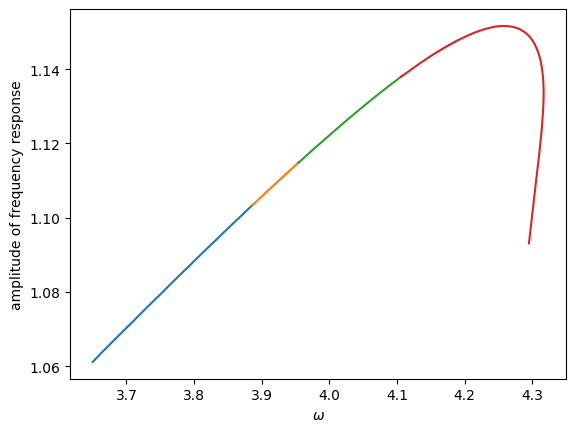

In [ ]:
is_inf = np.any(np.isinf(ys0), axis=1) | (ys0[:, -1] > 1e2)
amplitudes0 = np.linalg.norm(ys0[~is_inf][:, :-1], axis=1)
omegas0 = ys0[~is_inf][:, -1].real

if "ys1" in locals():
    amplitudes1 = np.linalg.norm(ys1[:, :-1], axis=1)
    omegas1 = ys1[:, -1].real

if "ys2" in locals():
    amplitudes2 = np.linalg.norm(ys2[:, :-1], axis=1)
    omegas2 = ys2[:, -1].real

if "ys3" in locals():
    amplitudes3 = np.linalg.norm(ys3[:, :-1], axis=1)
    omegas3 = ys3[:, -1].real

fig, ax = plt.subplots(1, 1)

s_ = np.s_[:]
ax.plot(omegas0[s_], amplitudes0[s_])

if "ys1" in locals():
    s_ = np.s_[:]
    ax.plot(omegas1[s_], amplitudes1[s_])

if "ys2" in locals():
    s_ = np.s_[:]
    ax.plot(omegas2[s_], amplitudes2[s_])

if "ys3" in locals():
    s_ = np.s_[:553]
    ax.plot(omegas3[s_], amplitudes3[s_])

ax.set_xlabel("$\omega$")
ax.set_ylabel("amplitude of frequency response")

plt.show()

In [ ]:
rel_errors3[500:553]

array([9.88025342e-05, 9.98489578e-05, 9.84915814e-05, 9.81621467e-05,
       9.84912149e-05, 9.92554648e-05, 9.78929435e-05, 9.76173776e-05,
       9.80374756e-05, 9.89168564e-05, 9.78088397e-05, 9.77621394e-05,
       9.83962869e-05, 9.94839943e-05, 9.86935801e-05, 9.89288073e-05,
       9.98290565e-05, 9.90805853e-05, 9.94201382e-05, 9.84531350e-05,
       9.87185771e-05, 9.97809288e-05, 9.94621853e-05, 9.83787586e-05,
       9.87280329e-05, 9.82254349e-05, 9.90294607e-05, 9.89857627e-05,
       9.85343841e-05, 9.95562277e-05, 9.84088958e-05, 9.91791470e-05,
       9.97157706e-05, 9.88516645e-05, 9.87687831e-05, 9.93418595e-05,
       9.92716016e-05, 9.91598248e-05, 9.94031608e-05, 9.92381557e-05,
       9.94679659e-05, 9.88887839e-05, 9.90769507e-05, 1.01897322e-04,
       1.10577551e-04, 1.24790558e-04, 1.45864652e-04, 1.77232629e-04,
       2.26403720e-04, 3.11027140e-04, 4.80637102e-04, 9.25699847e-04,
       3.08485271e-03])